In [59]:
%matplotlib inline
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Binarizer
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from helper import *
from mask_to_submission import *
from submission_to_mask import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
nb_images_to_load = 5 # Very important parameter --> Leads to overfit if too many
patch_size = 16
extract_features_method = extract_features_2d
foreground_threshold = 0.25
polynomial_degree = 1
nb_splits_kfold = 5

In [61]:
# Load a set of images
root_dir = "Datasets/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
imgs = [load_image(image_dir + files[i]) for i in range(nb_images_to_load)]

gt_dir = root_dir + "groundtruth/"
gt_imgs = [load_image(gt_dir + files[i]) for i in range(nb_images_to_load)]

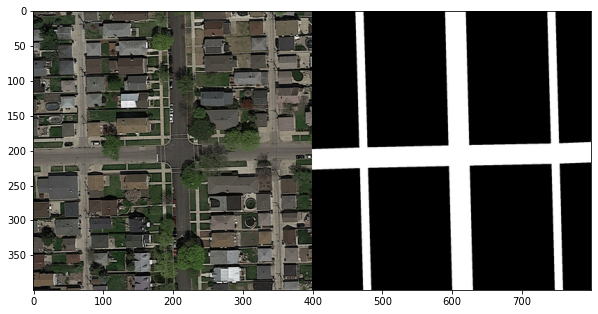

In [62]:
print_img_and_gt_img(imgs, gt_imgs, [0])

In [63]:
img_patches, gt_patches = extract_patches(imgs, gt_imgs, patch_size)

In [64]:
X = np.asarray([extract_features_method(img_patches[i]) for i in range(len(img_patches))])
y = np.asarray([patch_to_label(gt_patches[i], foreground_threshold) for i in range(len(gt_patches))])
print(X.shape, y.shape)

(3125, 2) (3125,)


In [65]:
print('Computed ' + str(X.shape[0]) + ' points')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(len(np.unique(y))))

Y0 = [i for i, j in enumerate(y) if j == 0]
Y1 = [i for i, j in enumerate(y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 3125 points
Feature dimension = 2
Number of classes = 2
Class 0: 2278 samples
Class 1: 847 samples


In [66]:
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from sklearn import dummy
from sklearn import ensemble
from sklearn import model_selection

In [67]:
def summary_cv_result(search,cv):
    Classifier = min(abs(search.cv_results_["mean_test_score"]))
    ClassifierIndex = np.argmin(abs(search.cv_results_["mean_test_score"]))
    ClassifierScore = []
    for i in range(0,cv):
        ClassifierScore.append(abs(search.cv_results_["split"+str(i)+"_test_score"][ClassifierIndex]))
    return(Classifier,ClassifierScore)

In [68]:
pip = Pipeline(steps=[("RandomForestClassifier", RandomForestClassifier())])

param_grid = {"RandomForestClassifier__random_state": [42],
             "RandomForestClassifier__max_depth": [10],
             "RandomForestClassifier__max_features": [0.5],
             "RandomForestClassifier__min_samples_leaf": [6],
             "RandomForestClassifier__min_samples_split": [3],
             "RandomForestClassifier__n_estimators": [5,10,15,20,25,30]}


RFGsearch = GridSearchCV(pip, param_grid, scoring="f1", cv=10)
RFGsearch.fit(X,y)
RandomForestClassifier, RandomForestClassifierScore = summary_cv_result(RFGsearch,10)

In [69]:
print(RandomForestClassifier, RandomForestClassifierScore)

0.4342909182173617 [0.4, 0.3478260869565218, 0.2647058823529412, 0.5575757575757575, 0.5359477124183007, 0.588235294117647, 0.5755395683453238, 0.38666666666666666, 0.366412213740458, 0.31999999999999995]


In [70]:
print(RFGsearch.best_params_,RFGsearch.best_score_)

{'RandomForestClassifier__max_depth': 10, 'RandomForestClassifier__max_features': 0.5, 'RandomForestClassifier__min_samples_leaf': 6, 'RandomForestClassifier__min_samples_split': 3, 'RandomForestClassifier__n_estimators': 20, 'RandomForestClassifier__random_state': 42} 0.467010572787322


In [71]:
interval=np.arange(5,20,1)

pip = Pipeline(steps=
    [#("StandardScaler", StandardScaler()),
    ("KNeighborsClassifier", KNeighborsClassifier())])

param_grid = {"KNeighborsClassifier__n_neighbors": interval,
             "KNeighborsClassifier__algorithm": ["auto"]}


KNNsearch = GridSearchCV(pip, param_grid, scoring="f1", cv=10)
KNNsearch.fit(X,y)
KNeighborsClassifierRMSE,KNeighborsClassifierScore = summary_cv_result(KNNsearch,10)

In [72]:
print(KNeighborsClassifierRMSE,KNeighborsClassifierScore)

0.4097763981162343 [0.39682539682539686, 0.35294117647058826, 0.21138211382113825, 0.4657534246575343, 0.5303030303030303, 0.6131386861313869, 0.5467625899280576, 0.34375000000000006, 0.36800000000000005, 0.2689075630252101]


In [73]:
print(RFGsearch.best_params_,RFGsearch.best_score_)

{'RandomForestClassifier__max_depth': 10, 'RandomForestClassifier__max_features': 0.5, 'RandomForestClassifier__min_samples_leaf': 6, 'RandomForestClassifier__min_samples_split': 3, 'RandomForestClassifier__n_estimators': 20, 'RandomForestClassifier__random_state': 42} 0.467010572787322


In [74]:
#interval=np.arange(1,1,1)

pip = Pipeline(steps=
    [#("StandardScaler", StandardScaler()),
    ("PolynomialFeatures", PolynomialFeatures()),
    ("LogisticRegression", LogisticRegression())])

param_grid = {"PolynomialFeatures__degree": [1,2]}

Polysearch = GridSearchCV(pip, param_grid, scoring="f1", cv=10)
Polysearch.fit(X,y)
PolynomialClassifierRMSE,PolynomialClassifierScore = summary_cv_result(Polysearch,10)

In [75]:
print(PolynomialClassifierRMSE,PolynomialClassifierRMSE)

0.0 0.0


In [76]:
print(Polysearch.best_params_,Polysearch.best_score_)

{'PolynomialFeatures__degree': 1} 0.0


In [77]:
pip = Pipeline(steps=
    [#("StandardScaler", StandardScaler()),
    ("SGDClassifier", SGDClassifier(penalty="elasticnet",learning_rate="optimal"))])

param_grid = {"SGDClassifier__l1_ratio": [0.15,0.5,0.99],
             "SGDClassifier__alpha": [0.0001],
             "SGDClassifier__loss": ["log", "hinge", "modified_huber"]}

SGDsearch = GridSearchCV(pip, param_grid, scoring="f1", cv=10)
SGDsearch.fit(X,y)
SGDClassifierRMSE,SGDClassifierScore = summary_cv_result(SGDsearch,10)

In [78]:
print(SGDClassifierRMSE,SGDClassifierScore)

0.0 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [79]:
print(SGDsearch.best_params_,SGDsearch.best_score_)

{'SGDClassifier__alpha': 0.0001, 'SGDClassifier__l1_ratio': 0.99, 'SGDClassifier__loss': 'modified_huber'} 0.34235470355787684


In [80]:
interval = np.arange(150,300,10)

pip = Pipeline(steps=
    [#("StandardScaler", StandardScaler()),
    ("DecisionTreeClassifier", DecisionTreeClassifier())])

param_grid = {"DecisionTreeClassifier__splitter" : ["best","random"],
              "DecisionTreeClassifier__min_samples_split" : interval,
              "DecisionTreeClassifier__min_samples_leaf" : [1,4,7,10]}

DTRsearch = GridSearchCV(pip, param_grid, scoring="f1", cv=10)
DTRsearch.fit(X,y)
DTRClassifierRMSE, DTRClassifierScore = summary_cv_result(DTRsearch,10)

In [81]:
print(DTRClassifierRMSE, DTRClassifierScore)

0.21385119287182883 [0.46478873239436624, 0.3410852713178295, 0.0, 0.0, 0.557142857142857, 0.5899280575539569, 0.0, 0.0, 0.0, 0.18556701030927836]


In [82]:
print(DTRsearch.best_params_, DTRsearch.best_score_)

{'DecisionTreeClassifier__min_samples_leaf': 4, 'DecisionTreeClassifier__min_samples_split': 170, 'DecisionTreeClassifier__splitter': 'best'} 0.48160677911232963


In [83]:
interval = np.arange(150,300,10)

pip = Pipeline(steps=
    [#("StandardScaler", StandardScaler()),
    ("ExtraTreesClassifier", ExtraTreesClassifier())])

param_grid = {"ExtraTreesClassifier__n_estimators" : [100],
              "ExtraTreesClassifier__min_samples_split" : [8],
              "ExtraTreesClassifier__min_samples_leaf" : [1]}

ETRsearch = GridSearchCV(pip, param_grid, scoring="f1", cv=10)
ETRsearch.fit(X,y)
ExtraTreesClassifierRMSE, ExtraTreesClassifierScore = summary_cv_result(ETRsearch,10)

In [84]:
print(ExtraTreesClassifierRMSE, ExtraTreesClassifierScore)

0.4661768594268706 [0.5248226950354609, 0.4000000000000001, 0.2814814814814815, 0.6144578313253012, 0.6206896551724139, 0.6285714285714286, 0.5594405594405594, 0.3432835820895523, 0.393939393939394, 0.29508196721311475]


In [85]:
print(ETRsearch.best_params_, ETRsearch.best_score_)

{'ExtraTreesClassifier__min_samples_leaf': 1, 'ExtraTreesClassifier__min_samples_split': 8, 'ExtraTreesClassifier__n_estimators': 100} 0.4661768594268706


In [86]:
pip = Pipeline(steps=
    [#("StandardScaler", StandardScaler()),
     ("AdaBoostClassifier", AdaBoostClassifier())])

param_grid = {}

ADAsearch = GridSearchCV(pip, param_grid, scoring="f1", cv=10)
ADAsearch.fit(X,y)
AdaBoostClassifierRMSE, AdaBoostClassifierScore = summary_cv_result(ADAsearch,10)

In [87]:
print(AdaBoostClassifierRMSE, AdaBoostClassifierScore)

0.4812124378640942 [0.4511278195488722, 0.3916083916083916, 0.2733812949640288, 0.6274509803921569, 0.6197183098591549, 0.6351351351351351, 0.5755395683453238, 0.45454545454545453, 0.42424242424242425, 0.35937499999999994]


In [88]:
print(ADAsearch.best_params_, ADAsearch.best_score_)

{} 0.4812124378640942


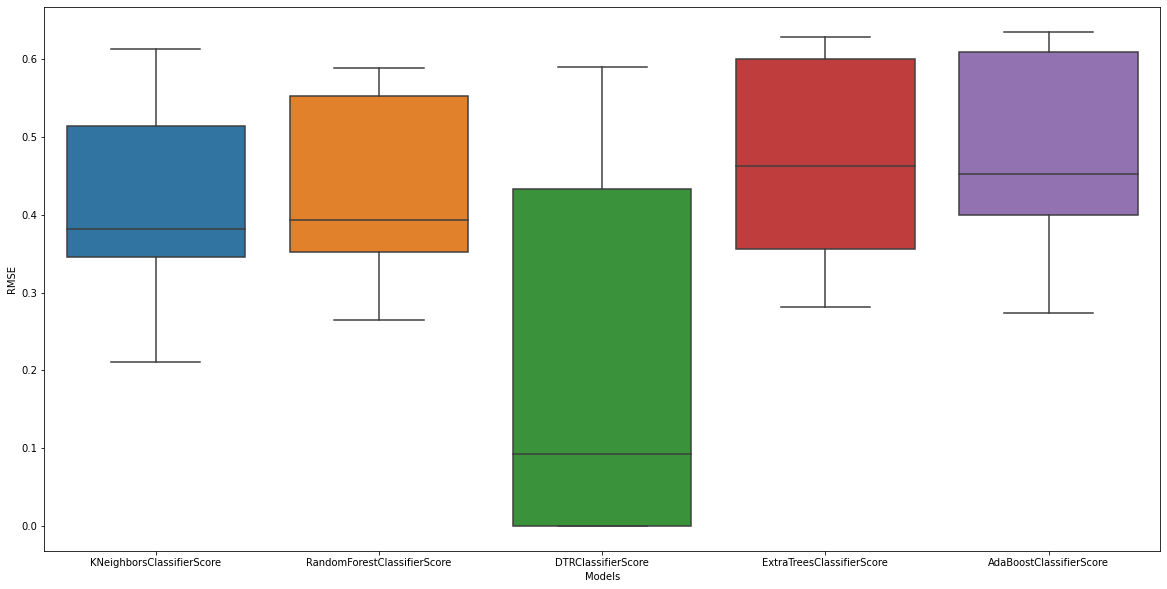

In [89]:
dataModel = {"KNeighborsClassifierScore": KNeighborsClassifierScore,
            "RandomForestClassifierScore" : RandomForestClassifierScore,
            "DTRClassifierScore" : DTRClassifierScore,
            "ExtraTreesClassifierScore": ExtraTreesClassifierScore,
            "AdaBoostClassifierScore" : AdaBoostClassifierScore}
df = pd.DataFrame(dataModel, columns = ["KNeighborsClassifierScore","RandomForestClassifierScore", "DTRClassifierScore", "ExtraTreesClassifierScore", "AdaBoostClassifierScore"])
plt.figure(figsize=(20,10))

ax = sns.boxplot(data=df)
ax.set_ylabel("RMSE")
ax.set_xlabel("Models")
plt.show()

In [102]:
# Run prediction on the img_idx-th image
img_idx = 1

models = {"KNeighborsClassifier": KNNsearch,
          "RandomForestClassifier" : RFGsearch,
          "DecisionTreeClassifier" : DTRsearch,
          "ExtraTreesClassifier": ETRsearch,
          "AdaBoostClassifier" : ADAsearch}

Xi = extract_img_features(image_dir + files[img_idx], patch_size)

In [103]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(len(imgs))]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(len(gt_imgs))]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

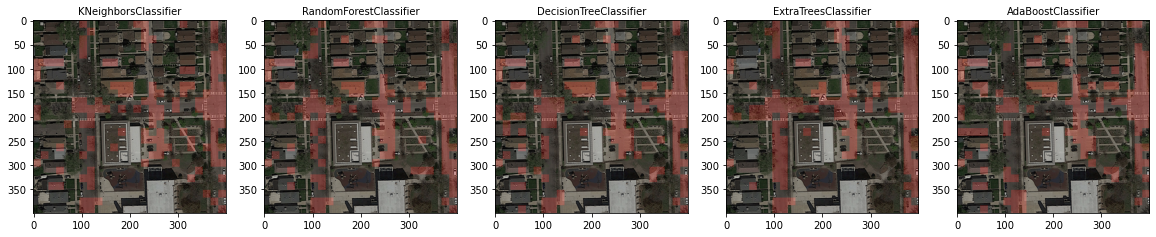

In [133]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]

fig, axs = plt.subplots(1, 5, figsize=(20, 20))
i = 0
for key, model in models.items():
    predicted_im = label_to_img(400, 400, patch_size, patch_size, model.predict(Xi))
    cimg = concatenate_images(imgs[img_idx], predicted_im)
    axs[i].imshow(cimg, cmap='Greys_r')
    axs[i].set_title(key, fontsize=10)
    new_img = make_img_overlay(imgs[img_idx], predicted_im)
    axs[i].imshow(new_img)
    i += 1